In [217]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle

from Extractor_module import SignalExtractor

In [218]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/result_df.csv"

MAX_SEQUENCE_LENGTH = 32
METRIC = ["EDA", "TEMP", "BVP", "ACC"]

## Methods for Plotting with Matplotlib

In this section, we define methods to visualize data distributions using Matplotlib. These methods help in understanding the class distribution before and after applying SMOTE, as well as the distribution of datasets across training, validation, and test sets.

### Plotting Class Distribution Before and After SMOTE

The `plot_smote_class_distribution` function plots the class distribution of the training labels before and after applying SMOTE (Synthetic Minority Over-sampling Technique). This visualization helps in understanding how SMOTE balances the class distribution.


### Plotting Dataset Distribution

The `plot_dataset_distribution` function plots a bar chart showing the sizes of the train, validation, and test sets. This visualization helps in understanding the distribution of samples across different datasets.

These methods provide visual insights into the data, which is crucial for understanding and improving the performance of machine learning models.

In [219]:
def plot_smote_class_distribution(y_train, y_train_resampled):
    """
    Plots the class distribution before and after applying SMOTE.

    Parameters:
    - y_train: Original training labels (dictionary).
    - y_train_resampled: Training labels after applying SMOTE (numpy array).
    """
    # Combine all labels from the y_train dictionary
    combined_y_train = np.concatenate(list(y_train.values()))

    # Class distribution before SMOTE
    class_distribution_before = Counter(combined_y_train)
    # Class distribution after SMOTE
    class_distribution_after = Counter(y_train_resampled.ravel())

    # Define labels
    labels = ['No Stress', 'Stress']

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot before SMOTE
    plt.subplot(1, 2, 1)
    plt.bar(labels, [class_distribution_before[0], class_distribution_before[1]], color='blue')
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)
    # Add absolute numbers on top of the bars
    for i, count in enumerate([class_distribution_before[0], class_distribution_before[1]]):
        plt.text(i, count + 5, str(count), ha='center', color='blue')

    # Plot after SMOTE
    plt.subplot(1, 2, 2)
    plt.bar(labels, [class_distribution_after[0], class_distribution_after[1]], color='green')
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)
    # Add absolute numbers on top of the bars
    for i, count in enumerate([class_distribution_after[0], class_distribution_after[1]]):
        plt.text(i, count + 5, str(count), ha='center', color='green')

    plt.tight_layout()
    plt.show()

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset_distribution(x_train, y_train, x_val, y_val, x_test_1, y_test_1, x_test_2, y_test_2):
    dataset_names = ['Train','Validation', 'Test Subject 1', 'Test Subject 2']
    
    # Calculate the lengths for 'EDA' signal in each dataset
    x_lengths = [
        len(x_train['EDA']), 
        len(x_val['EDA']), 
        len(x_test_1['EDA']), 
        len(x_test_2['EDA'])
    ]
    
    # Calculate the lengths for y datasets (labels)
    y_lengths = [
        len(y_train), 
        len(y_val), 
        len(y_test_1), 
        len(y_test_2)
    ]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35  # Width of the bars
    index = np.arange(len(dataset_names))  # Positions for the bars
    
    # Create bar plots for x and y datasets
    plt.bar(index, x_lengths, bar_width, color='b', alpha=0.6, label='X (Feature: EDA)')
    plt.bar(index + bar_width, y_lengths, bar_width, color='r', alpha=0.6, label='Y (Labels)')
    
    # Add absolute numbers on top of the bars
    for i in range(len(dataset_names)):
        plt.text(index[i], x_lengths[i] + 5, str(x_lengths[i]), ha='center', color='blue')
        plt.text(index[i] + bar_width, y_lengths[i] + 5, str(y_lengths[i]), ha='center', color='red')
    
    # Labels, title, etc.
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.xticks(index + bar_width / 2, dataset_names)
    plt.legend()
    
    # Show the plot
    plt.show()



In [221]:
def read_chunk(file_path, chunk_size=100000, usecols=None, dtype=None):
    """Reads a CSV file in chunks, adds a subject_id column, and returns a list of DataFrames for each chunk."""
    dataframes = []
    try:
        # Read the CSV in chunks
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, usecols=usecols, dtype=dtype):
            dataframes.append(chunk)
    except Exception as e:
        print(f"Error reading chunks from {file_path}: {e}")
    return dataframes

In [222]:
def load_data(subjects, sensors=("unknown"), chunk_size=100000, usecols=None, dtype=None):
    """Load data from multiple CSV files in chunks and concatenate them into a single DataFrame."""
    dataframes = []
        # Create file paths for each subject and sensor
    file_paths = [MAIN_PATH + f"/data/WESAD/{subject}/{subject}_{sensors}_data.csv" for subject in subjects]
    total_files = len(file_paths)

    # Use a thread pool to read files in chunks in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(read_chunk, file_path, chunk_size, usecols, dtype): file_path for file_path in file_paths}

        for i, future in enumerate(as_completed(futures)):
            file_path = futures[future]
            try:
                # Extend dataframes with the result of read_chunk
                dataframes.extend(future.result())
                print(f"Completed reading all chunks from {file_path} ({i + 1}/{total_files}).")
            except Exception as e:
                print(f"Error processing chunks from {file_path}: {e}")

    # Concatenate all DataFrames into one
    all_data = pd.concat(dataframes, ignore_index=True)
    
    # Sort by subject_id and time columns, assuming 'time' column exists in CSVs
    return all_data.sort_values(by=["ID", "StartTime"]).reset_index(drop=True)




In [223]:
import re

def filter_subjects(dictionary):
    """
    Filters the subjects' data from the dictionary and removes any suffix from the subject keys, 
    retaining only the `S{number}` format. Separates test subjects S16 and S17 from the rest.
    """
    test_subject_1 = None
    test_subject_2 = None
    sequence_data = {}

    # Loop through the dictionary to filter data by subject ID
    for key, value in dictionary.items():
        # Extract only the subject ID (S{number}) using regex
        match = re.match(r"(S\d+)", key)
        if match:
            subject_id = match.group(1)  # Get only S{number}, e.g., "S11"

            # Check for specific test subjects (S16 and S17) or add to the sequence_data
            if subject_id == 'S16':
                test_subject_1 = value
            elif subject_id == 'S17':
                test_subject_2 = value
            else:
                sequence_data[subject_id] = value  # Store the data with cleaned-up subject_id
        else:
            print(f"Warning: Could not determine subject ID format for key '{key}'.")

    # Check if data for S16 and S17 were found, log warnings if missing
    if test_subject_1 is None:
        print("Warning: No data found for test subject 1 (ID S16)")
    if test_subject_2 is None:
        print("Warning: No data found for test subject 2 (ID S17)")

    return sequence_data, test_subject_1, test_subject_2


In [224]:
def prepare_data(sequences_dict, features):
    """
    Prepare the data by extracting the specified features from the sequences dictionary.

    Args:
        sequences_dict (dict): Dictionary containing sequences of sensor data, where each key is a subject, 
                             and each value is a dictionary of features (e.g., {'EDA': data, 'TEMP': data}).
        features (list): List of features to extract from each subject's data.

    Returns:
        dict: Dictionary where each key is a subject, and each value is a dictionary of feature arrays.
              Example format: {'subject_key': {'EDA': array, 'TEMP': array, ...}, ...}
    """
    feature_arrays = {}

    # Loop through each subject in the sequences_dict dictionary
    for subject_key, subject_data in sequences_dict.items():
        # Initialize a dictionary to hold the features for the current subject
        subject_features = {}

        # Loop through the list of features to extract
        for feature in features:
            if feature in subject_data:
                # Convert feature data into a numpy array and add it to subject_features
                subject_features[feature] = np.array(subject_data[feature])
            else:
                print(f"Warning: Feature '{feature}' not found in subject '{subject_key}'.")

        # Add the subject's feature data to the main feature_arrays dictionary
        feature_arrays[subject_key] = subject_features

    return feature_arrays


In [225]:
import numpy as np
from imblearn.over_sampling import SMOTE

def apply_smote(x_train, y_train):
    """
    Reshape x_train to have signal types as keys and apply SMOTE to balance the dataset.
    
    Args:
        x_train (dict): Dictionary where each subject has signal data (BVP, ACC, TEMP, EDA).
                        The shape of each signal is (num_samples, sequence_length, 1).
        y_train (dict): Dictionary of labels for each subject, where each value is a (num_samples,) array.
    
    Returns:
        tuple: Resampled x_train (with signals as keys) and resampled y_train.
    """
    # Initialize lists to hold combined data for SMOTE
    combined_features = {'BVP': [], 'ACC': [], 'TEMP': [], 'EDA': []}
    combined_labels = []

    # Step 1: Organize x_train into signal-based keys and flatten data
    for subject, data in x_train.items():
        for signal, signal_data in data.items():
            # Flatten signal data (num_samples, sequence_length, 1) -> (num_samples, sequence_length)
            combined_features[signal].append(signal_data.reshape(signal_data.shape[0], -1))
        
        # Add labels for this subject
        combined_labels.extend(y_train[subject].ravel())  # Flatten the labels

    # Step 2: Stack features by signal type into single arrays
    for signal in combined_features:
        combined_features[signal] = np.vstack(combined_features[signal])  # Shape: (total_windows, signal_features)

    # Stack all signals into a combined feature array
    X_combined = np.hstack([combined_features['BVP'], combined_features['ACC'], combined_features['TEMP'], combined_features['EDA']])
    y_combined = np.array(combined_labels)  # Shape: (total_windows,)

    # Step 3: Apply SMOTE to the flattened feature set
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_combined, y_combined)

    # Step 4: Reshape the resampled data back into the original signal format
    num_resampled_samples = X_resampled.shape[0]
    bvp_size = combined_features['BVP'].shape[1]
    acc_size = combined_features['ACC'].shape[1]
    temp_size = combined_features['TEMP'].shape[1]
    eda_size = combined_features['EDA'].shape[1]

    # Reshape the resampled data back to its original shape
    bvp_resampled = X_resampled[:, :bvp_size].reshape(num_resampled_samples, bvp_size, 1)
    acc_resampled = X_resampled[:, bvp_size:bvp_size+acc_size].reshape(num_resampled_samples, acc_size, 1)
    temp_resampled = X_resampled[:, bvp_size+acc_size:bvp_size+acc_size+temp_size].reshape(num_resampled_samples, temp_size, 1)
    eda_resampled = X_resampled[:, bvp_size+acc_size+temp_size:].reshape(num_resampled_samples, eda_size, 1)

    # Step 5: Reconstruct x_train with signals as keys
    x_train_resampled = {
        'BVP': bvp_resampled,
        'ACC': acc_resampled,
        'TEMP': temp_resampled,
        'EDA': eda_resampled
    }

    return x_train_resampled, y_resampled.reshape(-1, 1)

# Example usage:
# resampled_x_train, resampled_y_train = prepare_and_apply_smote(x_train, y_train)


In [226]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_data(feature_arrays, y, test_size=0.3):
    """
    Split the data into training and validation sets for each feature, handling each feature's specific dimensions.
    
    Args:
        feature_arrays (dict): Dictionary where each key is a subject ID, and each value is a dictionary of features.
                               Example: {'subject_1': {'EDA': array, 'TEMP': array, ...}, ...}
        y (dict): Dictionary containing labels corresponding to each subject.
        test_size (float): Proportion of the dataset to include in the validation split.
    
    Returns:
        tuple: Dictionaries containing the training and validation splits for each subject, each feature, and the labels.
    """
    # Initialize dictionaries to hold the training and validation sets
    x_train, x_val = {}, {}
    y_train, y_val = {}, {}

    # Split for each subject individually
    for subject, features in feature_arrays.items():
        x_train[subject] = {}
        x_val[subject] = {}

        # Collect labels for the current subject (assuming it's scalar or needs replication)
        y_subject = y[subject]

        # Ensure y_subject is in an appropriate shape for splitting
        if isinstance(y_subject, (np.ndarray, list)) and len(y_subject) == 1:
            y_subject = np.array([y_subject[0]] * len(features['EDA']))  # Repeat the label for all data points

        # Perform train-test split for each feature for the current subject
        for feature_name, feature_data in features.items():
            # Ensure feature_data is a numpy array
            feature_data = np.array(feature_data)

            # Split feature data with corresponding labels
            x_train_feature, x_val_feature, y_train_subject, y_val_subject = train_test_split(
                feature_data, y_subject, test_size=test_size, random_state=42
            )
            
            # Store split data in nested dictionaries for the subject
            x_train[subject][feature_name] = x_train_feature
            x_val[subject][feature_name] = x_val_feature

        # Store split labels for the subject (they are the same across features)
        y_train[subject] = y_train_subject
        y_val[subject] = y_val_subject
    
    return x_train, x_val, y_train, y_val


In [227]:
def extract_labels_from_data(data, subject_name):
    """
    Extracts labels from a numpy array. Raises an error for unsupported data types.
    """
    if isinstance(data, np.ndarray):
        print(f"Labels count for {subject_name}: {len(data)}")
        return data
    else:
        raise TypeError(f"Unsupported data type '{type(data)}' for {subject_name}. Expected numpy.ndarray.")

def extract_labels(dictionary, t_df1, t_df2, label_column='labels'):
    """
    Extracts labels for the entire dataset, test subject 1, and test subject 2.
    """
    # Ensure the dictionary is of type 'dict', otherwise raise an error
    if not isinstance(dictionary, dict):
        raise TypeError(f"Expected 'dictionary' to be of type 'dict', but got {type(dictionary)}")

    # Extract labels for test subjects S16 and S17 using the helper function
    try:
        validation_labels_subject_1 = extract_labels_from_data(t_df1[label_column], "Subject 1 (S16)")
        validation_labels_subject_2 = extract_labels_from_data(t_df2[label_column], "Subject 2 (S17)")
    except KeyError as e:
        raise KeyError(f"Missing key '{label_column}' in test subject data: {e}")

    # Extract labels for all subjects in the dictionary
    all_labels = {}
    for subject_key, subject_data in dictionary.items():
        try:
            if label_column in subject_data:
                subject_labels = subject_data[label_column]
                all_labels[subject_key] = subject_labels
            else:
                print(f"Warning: '{label_column}' not found for {subject_key}")
        except Exception as e:
            print(f"Error processing {subject_key}: {e}")

    return all_labels, validation_labels_subject_1, validation_labels_subject_2


In [228]:
def save_datasets_to_pickle(x_train, y_train, x_val, y_val, x_test_1, y_test_1, x_test_2, y_test_2, save_directory="../data/results/"):
    """Save the datasets to a pickle file.
    Args:
        x_train (ndarray): Training feature data.
        y_train (ndarray): Training label data.
        x_val (ndarray): Validation feature data.
        y_val (ndarray): Validation label data.
        x_test_1 (ndarray): Test feature data for Subject 1.
        y_test_1 (ndarray): Test label data for Subject 1.
        x_test_2 (ndarray): Test feature data for Subject 2.
        y_test_2 (ndarray): Test label data for Subject 2.
        filename (str): The name of the file to save the datasets to (should end with .pkl).
    """
    try:
        # Dictionary to store all datasets
        datasets = {
            "x_train": x_train,
            "y_train": y_train,
            "x_val": x_val,
            "y_val": y_val,
            "x_test_1": x_test_1,
            "y_test_1": y_test_1,
            "x_test_2": x_test_2,
            "y_test_2": y_test_2
        }
        # Ensure the save directory exists
        os.makedirs(save_directory, exist_ok=True)
        # Save each dataset as a separate pickle file
        for name, data in datasets.items():
            save_path = f"{save_directory}{name}.pkl"
            with open(save_path, 'wb') as file:
                pickle.dump(data, file)
            print(f"{name} saved successfully to {save_path}")

    except Exception as e:
        raise RuntimeError(f"Failed to save datasets: {e}")


In [229]:
import numpy as np

def dict_to_ndarray(data_dict):
    """
    Converts a nested dictionary of subjects and signals to a single NumPy array.
    
    Args:
        data_dict (dict): Nested dictionary where each subject contains signals, and each signal is an ndarray.
        
    Returns:
        ndarray: 2D array where each row is a flattened window from each signal for each subject.
    """
    combined_data = []
    for subject, signals in data_dict.items():
        # Flatten each signal and concatenate along axis 1 (feature dimension)
        flattened_signals = np.hstack([signal.reshape(signal.shape[0], -1) for signal in signals.values()])
        combined_data.append(flattened_signals)
    
    # Stack all subjects' data into a single array
    return np.vstack(combined_data)

Labels count for Subject 1 (S16): 703
Labels count for Subject 2 (S17): 740
Resampled training data shapes: (11610, 256, 1), (11610, 1)
Training data shapes: (11610, 256, 1), (11610, 1)
Validation data shapes: (2828, 256), (2828, 1)
Test data shapes: (703, 256), (703,)


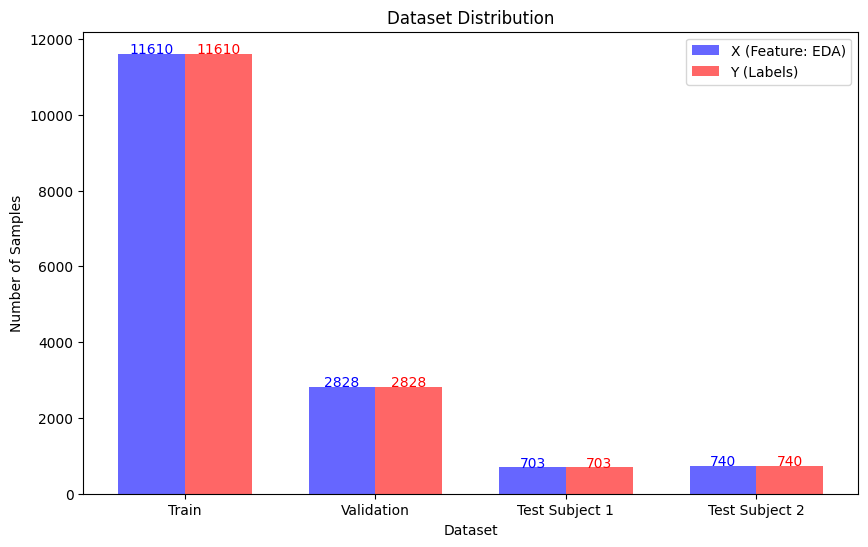

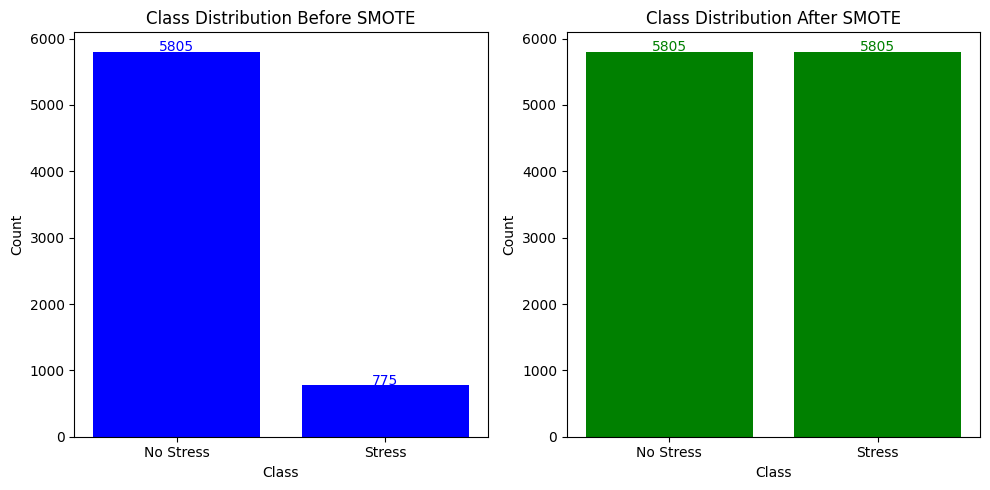

x_train saved successfully to ../data/results/x_train.pkl
y_train saved successfully to ../data/results/y_train.pkl
x_val saved successfully to ../data/results/x_val.pkl
y_val saved successfully to ../data/results/y_val.pkl
x_test_1 saved successfully to ../data/results/x_test_1.pkl
y_test_1 saved successfully to ../data/results/y_test_1.pkl
x_test_2 saved successfully to ../data/results/x_test_2.pkl
y_test_2 saved successfully to ../data/results/y_test_2.pkl


In [230]:
def main():
    features = ['EDA', 'BVP', 'ACC', 'TEMP']

    # Load the data from CSV files
    dictionary = SignalExtractor.load_data_from_pickle(r'C:\Master of Applied IT\data\processed_data')

    # Filter the data for the test subjects and the rest
    sequence_data, test_dataset1, test_dataset2 = filter_subjects(dictionary)

    # Extract labels for the training and test data
    y_sequence_data, y_test_subject_1, y_test_subject_2 = extract_labels(sequence_data, test_dataset1, test_dataset2)
   
    # Prepare the data for training
    feature_data = prepare_data(sequence_data, features)

    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = split_data(feature_data, y_sequence_data, test_size=0.3)

    # Apply SMOTE to balance the training data
    x_train_resampled, y_train_resampled = apply_smote(x_train, y_train)

    print(f"Resampled training data shapes: {x_train_resampled['BVP'].shape}, {y_train_resampled.shape}")
    
    # x_train_restructured = SignalExtractor.restructure_x_train(x_train_resampled)
    x_val_restructured, y_val_restructured = SignalExtractor.restructure_x_train_and_y_val(x_val, y_val)

    print(f"Training data shapes: {x_train_resampled['BVP'].shape}, {y_train_resampled.shape}")
    print(f"Validation data shapes: {x_val_restructured['BVP'].shape}, {y_val_restructured.shape}")
    print(f"Test data shapes: {test_dataset1['BVP'].shape}, {y_test_subject_1.shape}")

    plot_dataset_distribution(x_train_resampled, y_train_resampled, x_val_restructured, y_val_restructured, test_dataset1, y_test_subject_1, test_dataset2, y_test_subject_2)
    plot_smote_class_distribution(y_train, y_train_resampled)
    save_datasets_to_pickle(x_train_resampled, y_train_resampled, x_val_restructured, y_val_restructured, test_dataset1, y_test_subject_1, test_dataset2, y_test_subject_2)
    
main()

